# Objetivo

Desenvolver um modelo de machine learning para realizar análise de sentimentos em reviews de aplicativos. O projeto utilizará técnicas de processamento de linguagem natural (NLP) para identificar e classificar as emoções expressas nos textos. O objetivo é criar uma ferramenta que melhore a compreensão do feedback dos usuários e outros conteúdos textuais, fornecendo insights valiosos de forma automatizada.

### Configuração do ambiente

In [2]:
!pip install datasets huggingface_hub torch matplotlib scikit-learn
!pip install transformers --upgrade
!pip install accelerate>0.21.0
#!pip install nltk
!pip install spacy # usando spacy já que a lib nltk não está funcionando (LookupError)
!python -m spacy download pt_core_news_sm

import os

# Desativa o paralelismo para evitar deadlocks
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Imports necessários
import pandas as pd
import numpy as np
import pickle
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
#import nltk
#nltk_data_path = os.path.abspath('./nltk_data')
#nltk.data.path.append(nltk_data_path)
#nltk.download('stopwords', download_dir=nltk_data_path, force=True)
#nltk.download('punkt', download_dir=nltk_data_path, force=True)
#from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize

import spacy

from sklearn.feature_extraction.text import CountVectorizer

from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding, TrainingArguments, Trainer

import datasets
from datasets import Dataset, load_metric


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 4.7 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')


### Dataset

O dataset contém avaliações e notas dos 10 aplicativos mais populares na categoria de comida e bebidas, disponíveis na Google Play Store do Brasil. As notas variam de 1 a 5, e a ideia é fazer a seguinte classificação:

* 1 e 2: Avaliações Negativas
* 4 e 5: Avaliações Positivas
* As avaliações neutras (3) serão descartadas para simplificação do problema.

### Descrição das colunas:

* reviewId: ID da avaliação
* userName: Nome de usuário
* userImage: Avatar do usuário
* content: Texto da avaliação
* score: Nota atribuída na avaliação
* thumbsUpCount: Número de curtidas
* reviewCreatedVersion: Versão do aplicativo no momento da avaliação
* at: Data da avaliação
* replyContent: Texto da resposta à avaliação
* repliedAt: Data da resposta à avaliação
* appVersion: Versão do aplicativo
* sortOrder: Ordem de classificação
* appId: ID do aplicativo





### Carregando o dataset

In [3]:
# Informa a URL de importação do dataset
#url = "https://raw.githubusercontent.com/bpbastos/sentiment-analysis-ml-api/main/android_app_reviews.csv?token=GHSAT0AAAAAACSFFAPRMUHD2ZIBMDIWUJSWZWRHYEQ"
url = "../data/android_app_reviews.csv"

# Lê o arquivo
dataset = pd.read_csv(url, delimiter=',', encoding='utf-8')

#Desprezando os comentários com score 3 (neutro)
dataset = dataset[dataset['score'] != 3]

#
dataset.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,sortOrder,appId
0,9b2090fb-2acf-4ade-bff4-1bd65f714e89,Julia Lopes Ogleari,https://play-lh.googleusercontent.com/a-/ALV-U...,Só decepções. As últimas vezes que pedi com es...,1,49,10.32.0,2024-08-27 00:32:41,NaN,NaN,10.32.0,most_relevant,br.com.brainweb.ifood
1,fb9bccfd-573d-47cf-aafe-fbeafe53f55b,David Paul,https://play-lh.googleusercontent.com/a-/ALV-U...,Era muito bom quando a preocupação era atender...,1,5,10.27.0,2024-08-28 01:25:52,NaN,NaN,10.27.0,most_relevant,br.com.brainweb.ifood
2,a8da45e3-66c6-44b2-8ff3-905c9c266914,Larissa Keity,https://play-lh.googleusercontent.com/a-/ALV-U...,É frustrante vc fazer um pedido num restaurant...,1,8,10.32.0,2024-08-28 02:55:34,NaN,NaN,10.32.0,most_relevant,br.com.brainweb.ifood
3,edeb5bbd-7d01-4c02-88b2-c65c3b82373b,Lorenna Petri,https://play-lh.googleusercontent.com/a-/ALV-U...,O processo de cancelamento é dificultado para ...,1,201,10.28.0,2024-07-30 11:40:22,NaN,NaN,10.28.0,most_relevant,br.com.brainweb.ifood
4,1fa4b8eb-9423-4f8e-9ba7-3be0d5805f96,Jordana Araujo,https://play-lh.googleusercontent.com/a-/ALV-U...,Eu não consigo mais usar o app. Instalei ele d...,1,389,10.28.0,2024-08-03 16:26:19,NaN,NaN,10.28.0,most_relevant,br.com.brainweb.ifood


In [4]:
# Informações gerais sobre o dataset
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8000 entries, 0 to 11999
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              8000 non-null   object
 1   userName              8000 non-null   object
 2   userImage             8000 non-null   object
 3   content               8000 non-null   object
 4   score                 8000 non-null   int64 
 5   thumbsUpCount         8000 non-null   int64 
 6   reviewCreatedVersion  7244 non-null   object
 7   at                    8000 non-null   object
 8   replyContent          3300 non-null   object
 9   repliedAt             3300 non-null   object
 10  appVersion            7244 non-null   object
 11  sortOrder             8000 non-null   object
 12  appId                 8000 non-null   object
dtypes: int64(2), object(11)
memory usage: 875.0+ KB


### Pré-processamento
Distribuição dos reviews por nota

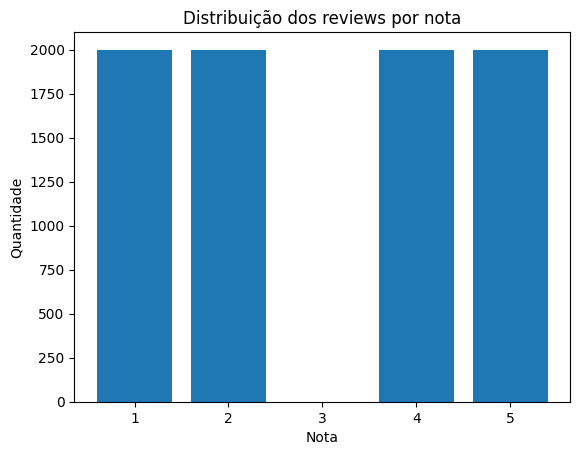

In [5]:
# Calcula a contagem de cada valor de 'score'
score_counts = dataset['score'].value_counts()

# Histograma do número de reviews de acordo com a nota:
plt.bar(score_counts.index, score_counts.values)
plt.xlabel('Nota')
plt.ylabel('Quantidade')
plt.title('Distribuição dos reviews por nota')
plt.show()

Balanceamento do dataset

In [6]:
def to_sentiment(rating):
  rating = int(rating)
  if rating <= 2:
    return 0
  elif rating > 3:
    return 1

dataset['sentiment'] = dataset.score.apply(to_sentiment)

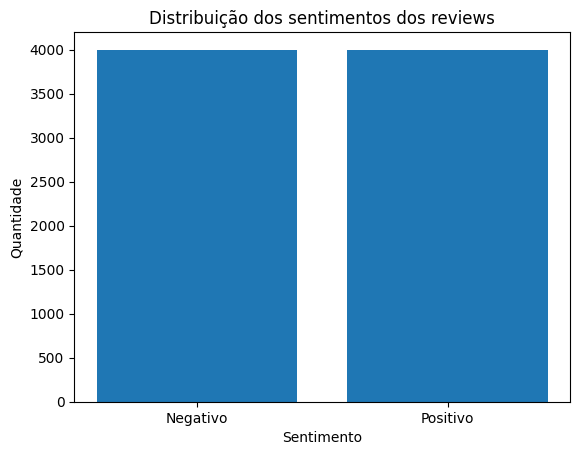

In [7]:
class_names = ['Negativo', 'Positivo']
sentiment_counts = dataset['sentiment'].value_counts()
plt.bar(class_names, sentiment_counts.values)
plt.xlabel('Sentimento')
plt.ylabel('Quantidade')
plt.title('Distribuição dos sentimentos dos reviews')
plt.show()


### Limpeza e Vetorização do texto

Adicionando novas stop words ao dicionário da biblioteca spacy

In [8]:
# Execute python -m spacy download pt_core_news_sm para download do modelo em português

# Stop words em português
novas_stop_words = [ 'a', 'à', 'adeus', 'agora', 'aí', 'ainda', 'além', 'algo', 'alguém', 'algum', 'alguma', 'algumas', 'alguns', 'ali', 'ampla', 'amplas', 'amplo', 'amplos', 'ano', 'anos', 'ante', 'antes', 'ao', 'aos', 'apenas', 'apoio', 'após', 'aquela', 'aquelas', 'aquele', 'aqueles', 'aqui', 'aquilo', 'área', 'as', 'às', 'assim', 'até', 'atrás', 'através', 'baixo', 'bastante', 'bem', 'boa', 'boas', 'bom', 'bons', 'breve', 'cá', 'cada', 'catorze', 'cedo', 'cento', 'certamente', 'certeza', 'cima', 'cinco', 'coisa', 'coisas', 'com', 'como', 'conselho', 'contra', 'contudo', 'custa', 'da', 'dá', 'dão', 'daquela', 'daquelas', 'daquele', 'daqueles', 'dar', 'das', 'de', 'debaixo', 'dela', 'delas', 'dele', 'deles', 'demais', 'dentro', 'depois', 'desde', 'dessa', 'dessas', 'desse', 'desses', 'desta', 'destas', 'deste', 'destes', 'deve', 'devem', 'devendo', 'dever', 'deverá', 'deverão', 'deveria', 'deveriam', 'devia', 'deviam', 'dez', 'dezanove', 'dezasseis', 'dezassete', 'dezoito', 'dia', 'diante', 'disse', 'disso', 'disto', 'dito', 'diz', 'dizem', 'dizer', 'do', 'dois', 'dos', 'doze', 'duas', 'dúvida', 'e', 'é', 'ela', 'elas', 'ele', 'eles', 'em', 'embora', 'enquanto', 'entre', 'era', 'eram', 'éramos', 'és', 'essa', 'essas', 'esse', 'esses', 'esta', 'está', 'estamos', 'estão', 'estar', 'estas', 'estás', 'estava', 'estavam', 'estávamos', 'este', 'esteja', 'estejam', 'estejamos', 'estes', 'esteve', 'estive', 'estivemos', 'estiver', 'estivera', 'estiveram', 'estivéramos', 'estiverem', 'estivermos', 'estivesse', 'estivessem', 'estivéssemos', 'estiveste', 'estivestes', 'estou', 'etc', 'eu', 'exemplo', 'faço', 'falta', 'favor', 'faz', 'fazeis', 'fazem', 'fazemos', 'fazendo', 'fazer', 'fazes', 'feita', 'feitas', 'feito', 'feitos', 'fez', 'fim', 'final', 'foi', 'fomos', 'for', 'fora', 'foram', 'fôramos', 'forem', 'forma', 'formos', 'fosse', 'fossem', 'fôssemos', 'foste', 'fostes', 'fui', 'geral', 'grande', 'grandes', 'grupo', 'há', 'haja', 'hajam', 'hajamos', 'hão', 'havemos', 'havia', 'hei', 'hoje', 'hora', 'horas', 'houve', 'houvemos', 'houver', 'houvera', 'houverá', 'houveram', 'houvéramos', 'houverão', 'houverei', 'houverem', 'houveremos', 'houveria', 'houveriam', 'houveríamos', 'houvermos', 'houvesse', 'houvessem', 'houvéssemos', 'isso', 'isto', 'já', 'la', 'lá', 'lado', 'lhe', 'lhes', 'lo', 'local', 'logo', 'longe', 'lugar', 'maior', 'maioria', 'mais', 'mal', 'mas', 'máximo', 'me', 'meio', 'menor', 'menos', 'mês', 'meses', 'mesma', 'mesmas', 'mesmo', 'mesmos', 'meu', 'meus', 'mil', 'minha', 'minhas', 'momento', 'muita', 'muitas', 'muito', 'muitos', 'na', 'nada', 'não', 'naquela', 'naquelas', 'naquele', 'naqueles', 'nas', 'nem', 'nenhum', 'nenhuma', 'nessa', 'nessas', 'nesse', 'nesses', 'nesta', 'nestas', 'neste', 'nestes', 'ninguém', 'nível', 'no', 'noite', 'nome', 'nos', 'nós', 'nossa', 'nossas', 'nosso', 'nossos', 'nova', 'novas', 'nove', 'novo', 'novos', 'num', 'numa', 'número', 'nunca', 'o', 'obra', 'obrigada', 'obrigado', 'oitava', 'oitavo', 'oito', 'onde', 'ontem', 'onze', 'os', 'ou', 'outra', 'outras', 'outro', 'outros', 'para', 'parece', 'parte', 'partir', 'paucas', 'pela', 'pelas', 'pelo', 'pelos', 'pequena', 'pequenas', 'pequeno', 'pequenos', 'per', 'perante', 'perto', 'pode', 'pude', 'pôde', 'podem', 'podendo', 'poder', 'poderia', 'poderiam', 'podia', 'podiam', 'põe', 'põem', 'pois', 'ponto', 'pontos', 'por', 'porém', 'porque', 'porquê', 'posição', 'possível', 'possivelmente', 'posso', 'pouca', 'poucas', 'pouco', 'poucos', 'primeira', 'primeiras', 'primeiro', 'primeiros', 'própria', 'próprias', 'próprio', 'próprios', 'próxima', 'próximas', 'próximo', 'próximos', 'pude', 'puderam', 'quais', 'quáis', 'qual', 'quando', 'quanto', 'quantos', 'quarta', 'quarto', 'quatro', 'que', 'quê', 'quem', 'quer', 'quereis', 'querem', 'queremas', 'queres', 'quero', 'questão', 'quinta', 'quinto', 'quinze', 'relação', 'sabe', 'sabem', 'são', 'se', 'segunda', 'segundo', 'sei', 'seis', 'seja', 'sejam', 'sejamos', 'sem', 'sempre', 'sendo', 'ser', 'será', 'serão', 'serei', 'seremos', 'seria', 'seriam', 'seríamos', 'sete', 'sétima', 'sétimo', 'seu', 'seus', 'sexta', 'sexto', 'si', 'sido', 'sim', 'sistema', 'só', 'sob', 'sobre', 'sois', 'somos', 'sou', 'sua', 'suas', 'tal', 'talvez', 'também', 'tampouco', 'tanta', 'tantas', 'tanto', 'tão', 'tarde', 'te', 'tem', 'tém', 'têm', 'temos', 'tendes', 'tendo', 'tenha', 'tenham', 'tenhamos', 'tenho', 'tens', 'ter', 'terá', 'terão', 'terceira', 'terceiro', 'terei', 'teremos', 'teria', 'teriam', 'teríamos', 'teu', 'teus', 'teve', 'ti', 'tido', 'tinha', 'tinham', 'tínhamos', 'tive', 'tivemos', 'tiver', 'tivera', 'tiveram', 'tivéramos', 'tiverem', 'tivermos', 'tivesse', 'tivessem', 'tivéssemos', 'tiveste', 'tivestes', 'toda', 'todas', 'todavia', 'todo', 'todos', 'trabalho', 'três', 'treze', 'tu', 'tua', 'tuas', 'tudo', 'última', 'últimas', 'último', 'últimos', 'um', 'uma', 'umas', 'uns', 'vai', 'vais', 'vão', 'vários', 'vem', 'vêm', 'vendo', 'vens', 'ver', 'vez', 'vezes', 'viagem', 'vindo', 'vinte', 'vir', 'você', 'vocês', 'vos', 'vós', 'vossa', 'vossas', 'vosso', 'vossos', 'zero', '1', '2', '3', '4', '5', '6', '7', '8', '9', '0', '_' ]

# Carregue o modelo em português
nlp = spacy.load("pt_core_news_sm")

# Adiciona cada palavra da lista às stop words do spaCy
for word in novas_stop_words:
    nlp.Defaults.stop_words.add(word)
    # Marca como stop word no vocabulário
    nlp.vocab[word].is_stop = True

Limpando, removendo stop words e lematizando o texto 

In [9]:
print('Sem processamento:', dataset['content'].iloc[0])

# Define a função para remover caracteres especiais
def remove_special_characters(text):
    return ''.join(char for char in text if char not in '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~')

# Define a função para converter todos os caracteres para minúsculo
def to_lowercase(text):
    return text.lower()

# Função para remover stopwords
def remove_stopwords(text):
    doc = nlp(text)
    return ' '.join([token.text for token in doc if not token.is_stop])

# Função para lematizar o texto
def lemmatize_text(text):
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc])

def clean_text(text_list):
    # Converte todos os elementos para strings
    cleaned_text_list = text_list.astype(str)

    # Aplica a função para remover caracteres especiais 
    cleaned_text_list = cleaned_text_list.apply(remove_special_characters)

    # Aplica a função para converter todos os caracteres para minúsculo
    cleaned_text_list = cleaned_text_list.apply(to_lowercase)

    # Aplica a função para remover stopwords
    cleaned_text_list = cleaned_text_list.apply(remove_stopwords)

    # Aplica a função para lematizar o texto
    cleaned_text_list = cleaned_text_list.apply(lemmatize_text)

    return cleaned_text_list

# Converte todos os elementos na coluna 'content' para strings
cleaned_dataset = clean_text(dataset['content'])

# Imprime o texto após o processamento
print('Com processamento:', cleaned_dataset.iloc[0])

Sem processamento: Só decepções. As últimas vezes que pedi com esse aplicativo, TODAS deram ruim com a entrega. Seja faltando itens, seja entregador que some com a comida, seja lá o que for que dá pra acontecer de errado, acontece. Serviço está horrivrl e por mais que dêem o reembolso, ainda não vale a pena o stress. Desinstalando sem nenhum pesar. Recomendo a todos que façam o mesmo pois a tendência é piorar.
Com processamento: decepção pedir aplicativo dar ruim entregar faltar item entregador some comer pra acontecer errar acontecer serviço horrivrl dêem reembolso valer pena stress desinstalar pesar recomer façam tendência piorar


Convertendo o texto em vetor

In [10]:
# Separando entrada e saída
X = cleaned_dataset  # Texto do review limpo
y = dataset['sentiment'] # Sentimento 0(negativo)/1(positivo)

# Vetorização do texto usando CountVectorizer
vectorizer = CountVectorizer(analyzer = "word")

# Ajuste e transformação no conjunto de treino
X = vectorizer.fit_transform(X)

## Modelagem
### Sklearn

Separação em conjunto de treino e conjunto de teste com holdout

In [11]:
test_size = 0.20 # tamanho do conjunto de teste
seed = 7 # semente aleatória

# Dividindo os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=test_size, shuffle=True, random_state=seed, stratify=y) # holdout com estratificação

# Parâmetros e partições da validação cruzada
scoring = 'accuracy'
num_particoes = 10
kfold = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=seed) # validação cruzada com estratificação

LR: 0.806719 (0.013018)
KNN: 0.668281 (0.010529)
CART: 0.763594 (0.015626)
NB-Gaussian: 0.650000 (0.014987)
NB-Multinomial: 0.775625 (0.016700)
NB-Bernoulli: 0.743437 (0.017312)
SVM: 0.802812 (0.012119)
Bagging: 0.788750 (0.011154)
RF: 0.819844 (0.014491)
ET: 0.822813 (0.014892)
Ada: 0.749844 (0.015443)
GB: 0.755156 (0.014939)
Voting: 0.816094 (0.007560)


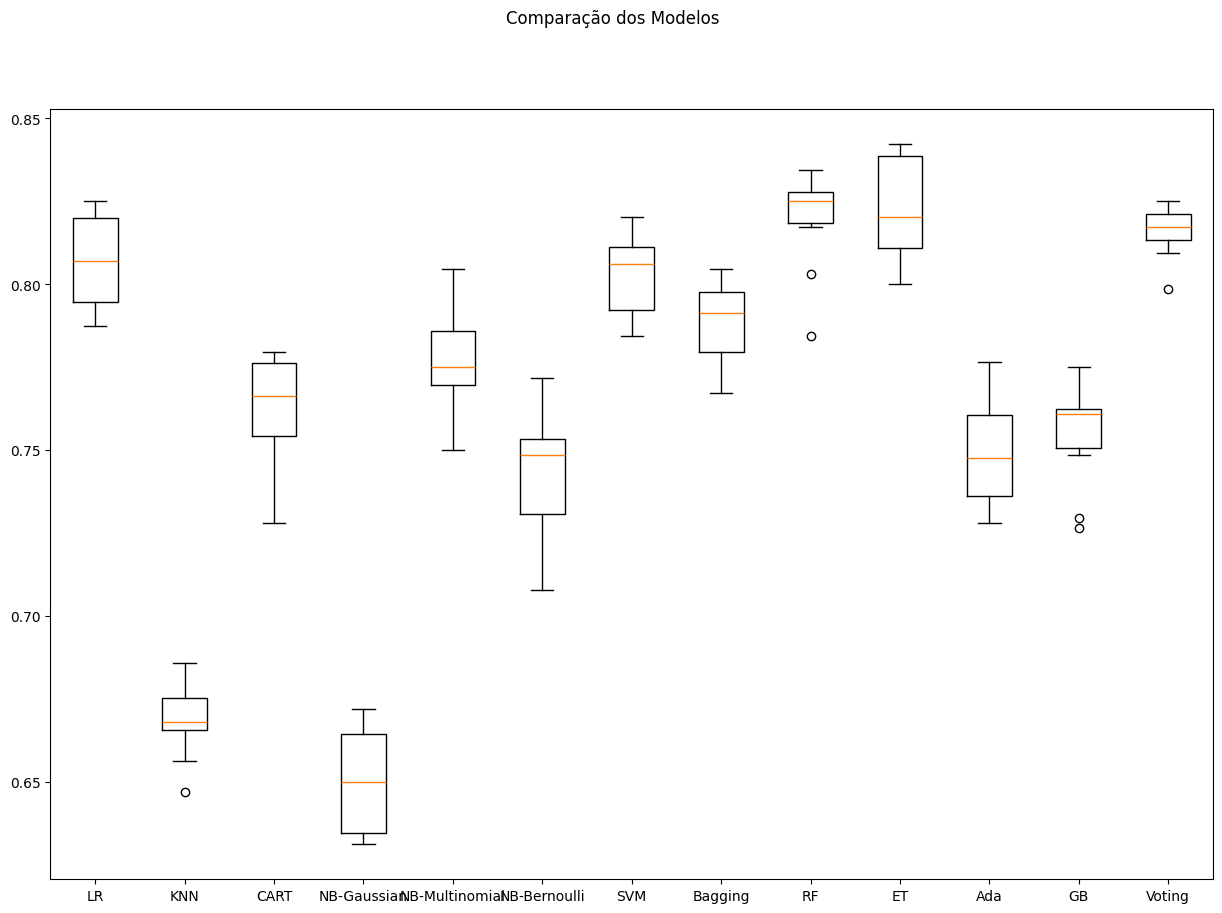

In [85]:
np.random.seed(7) # definindo uma semente global

# Lista que armazenará os modelos
models = []

# Criando os modelos e adicionando-os na lista de modelos
models.append(('LR', LogisticRegression(max_iter=200)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB-Gaussian', GaussianNB()))
models.append(('NB-Multinomial', MultinomialNB(alpha=1.0, fit_prior=True)))
models.append(('NB-Bernoulli', BernoulliNB(alpha=1.0, fit_prior=True)))
models.append(('SVM', SVC()))

# Definindo os parâmetros do classificador base para o BaggingClassifier
base = DecisionTreeClassifier()
num_trees = 100
max_features = 3

# Criando os modelos para o VotingClassifier
bases = []
model1 = LogisticRegression(max_iter=200)
bases.append(('logistic', model1))
model2 = DecisionTreeClassifier()
bases.append(('cart', model2))
model3 = SVC()
bases.append(('svm', model3))

# Criando os ensembles e adicionando-os na lista de modelos
models.append(('Bagging', BaggingClassifier(estimator=base, n_estimators=num_trees)))
models.append(('RF', RandomForestClassifier(n_estimators=num_trees, max_features=max_features)))
models.append(('ET', ExtraTreesClassifier(n_estimators=num_trees, max_features=max_features)))
models.append(('Ada', AdaBoostClassifier(n_estimators=num_trees)))
models.append(('GB', GradientBoostingClassifier(n_estimators=num_trees)))
models.append(('Voting', VotingClassifier(bases)))

# Listas para armazenar os resultados
results = []
names = []

# Avaliação dos modelos
for name, model in models:
    if name == 'NB-Gaussian':
        cv_results = cross_val_score(model, X_train.toarray(), y_train, cv=kfold, scoring=scoring)
    else:
        cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)    
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(15,10))
fig.suptitle('Comparação dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Otimização dos hiperparâmetros

In [86]:
# Semente global
np.random.seed(7)

# Estimador base
base_estimator = DecisionTreeClassifier()
num_trees = 100
max_features = 3

# Criando os modelos para o VotingClassifier
bases = []
model1 = LogisticRegression(max_iter=200)
bases.append(('logistic', model1))
model2 = DecisionTreeClassifier()
bases.append(('cart', model2))
model3 = SVC()
bases.append(('svm', model3))

# Lista de modelos
models = []

# Criando os ensembles e adicionando-os na lista de modelos 4 melhores modelos
models.append(('lr', LogisticRegression(max_iter=5000)))
models.append(('rf', RandomForestClassifier()))
models.append(('et', ExtraTreesClassifier()))
models.append(('voting', VotingClassifier(estimators=bases, voting='hard')))

# Definindo os componentes do pipeline
standard_scaler = ('StandardScaler', StandardScaler(with_mean=False)) # Precisei adicionar o parametro `with_mean=False` para trabalhar com matriz esparsa (CountVectorizer)
max_abs_scaler = ('MaxAbsScaler', MaxAbsScaler()) # Precisei alterar para o MaxAbsScaler para trabalhar com matriz esparsa (CountVectorizer)

# Criação dos pipelines
pipelines = []

# Criando pipelines para cada modelo
for name, model in models:
    pipelines.append((name + '-orig', Pipeline(steps=[(name, model)])))
    pipelines.append((name + '-padr', Pipeline(steps=[standard_scaler, (name, model)])))
    pipelines.append((name + '-norm', Pipeline(steps=[max_abs_scaler, (name, model)])))

param_grids = {
    'lr': {
        'lr__C': [0.01, 0.1, 1, 10, 100],
        'lr__solver': ['liblinear', 'saga'],
    },
    'rf': {
        'rf__n_estimators': [10, 50, 100, 200],
        'rf__max_features': ['auto', 'sqrt', 'log2'],
        'rf__max_depth': [None, 10, 20, 30],
        'rf__min_samples_split': [2, 5, 10],
        'rf__min_samples_leaf': [1, 2, 4]
    },    
    'et': {
        'et__n_estimators': [10, 50, 100, 200],
        'et__max_features': ['auto', 'sqrt', 'log2'],
        'et__max_depth': [None, 10, 20, 30],
        'et__min_samples_split': [2, 5, 10],
        'et__min_samples_leaf': [1, 2, 4],
    },
    'voting': {
        # Para VotingClassifier, geralmente não há hiperparâmetros para ajustar diretamente
        # Ajustar os hiperparâmetros dos estimadores base individualmente se necessário
    }    
}

# Executa o GridSearchCV para cada pipeline
for name, pipeline in pipelines:
    model_type = name.split('-')[0]
    param_grid = param_grids[model_type]
    grid = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring=scoring, cv=kfold, n_jobs=-1) #  n_jobs=-1 usa todos os núcleos do processador
    grid.fit(X_train, y_train) 
    # Imprimindo a melhor configuração
    print("Modelo: %s - Melhor: %f usando %s" % (name, grid.best_score_, grid.best_params_))

Modelo: lr-orig - Melhor: 0.807500 usando {'lr__C': 1, 'lr__solver': 'saga'}
Modelo: lr-padr - Melhor: 0.816563 usando {'lr__C': 0.01, 'lr__solver': 'saga'}
Modelo: lr-norm - Melhor: 0.812187 usando {'lr__C': 1, 'lr__solver': 'saga'}
Modelo: rf-orig - Melhor: 0.827344 usando {'rf__max_depth': None, 'rf__max_features': 'log2', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 10, 'rf__n_estimators': 200}
Modelo: rf-padr - Melhor: 0.826875 usando {'rf__max_depth': None, 'rf__max_features': 'log2', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 5, 'rf__n_estimators': 100}
Modelo: rf-norm - Melhor: 0.828594 usando {'rf__max_depth': None, 'rf__max_features': 'log2', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 5, 'rf__n_estimators': 200}
Modelo: et-orig - Melhor: 0.831094 usando {'et__max_depth': None, 'et__max_features': 'log2', 'et__min_samples_leaf': 1, 'et__min_samples_split': 10, 'et__n_estimators': 100}
Modelo: et-padr - Melhor: 0.831406 usando {'et__max_depth': None, 'e

Finalização do Modelo

In [12]:
# Avaliação do modelo com o conjunto de teste
# Melhor modelo
# Modelo: et-norm - Melhor: 0.831719 usando {'et__max_depth': None, 'et__max_features': 'log2', 'et__min_samples_leaf': 1, 'et__min_samples_split': 10, 'et__n_estimators': 200}

np.random.seed(7)

# Preparação do modelo
scaler = MaxAbsScaler().fit(X_train)
rescaledX = scaler.transform(X_train) # aplicação da normalização no conjunto de treino
model = ExtraTreesClassifier(n_estimators=200, max_depth=None, min_samples_split=10, min_samples_leaf=1, max_features='log2') # modelo ExtraTreesClassifier
model.fit(rescaledX, y_train) # treinamento do modelo

# Estimativa da acurácia no conjunto de teste
rescaledTestX = scaler.transform(X_test) # aplicação da normalização no conjunto de teste
predictions = model.predict(rescaledTestX)
print(accuracy_score(y_test, predictions))

0.858125


Rodando o modelo a partir de um pipeline com os hiperparâmetros otimizados.

In [13]:
np.random.seed(7)

model = ExtraTreesClassifier(n_estimators=200, max_depth=None, min_samples_split=10, min_samples_leaf=1, max_features='log2', bootstrap=False) # modelo ExtraTreesClassifier

pipeline = Pipeline(steps=[('MaxAbsScaler',  MaxAbsScaler()), ('et', model)])

pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)
print(accuracy_score(y_test, predictions))

0.858125


### Simulando a aplicação do modelo em dados não vistos

In [16]:
# Novos dados - não sabemos a classe!
entrada = [
    'Excelente app! A entrega foi super rápida, e a comida chegou quentinha. Adorei a variedade de restaurantes disponíveis. Super recomendo para quem gosta de praticidade!', # 1 (Positivo)
    'O aplicativo é super intuitivo e fácil de usar. Encontrei meus drinks favoritos em minutos, e o pagamento foi muito simples. Perfeito para uma noite em casa!', # 1 (Positivo)
    'O melhor app de delivery que já usei! Além das opções saudáveis, a entrega é sempre no horário e com um ótimo atendimento. Nota 10!', # 1 (Positivo)
    'Aplicativo maravilhoso! A interface é linda e super fácil de usar. Os cupons de desconto são um bônus que faz toda a diferença! 🤑💯', # 1 (Positivo)
    'Gostei muito do app! A função de rastreamento em tempo real da entrega é excelente. Nunca mais fiquei na dúvida sobre o horário de chegada!', # 1 (Positivo)
    'A experiência foi frustrante. O aplicativo travou várias vezes, e meu pedido chegou errado. Além disso, o suporte ao cliente demorou muito para responder.', # 0 (Negativo)
    'Esperava mais do serviço. A comida chegou fria e com apresentação ruim. O app tem um layout bonito, mas isso não compensa a má qualidade da entrega.', # 0 (Negativo)
    'Péssimo! A entrega demorou quase duas horas e, quando finalmente chegou, a comida estava completamente gelada. Não recomendo. ', # 0 (Negativo)
    'Fiquei muito decepcionado. A interface do app é confusa e difícil de navegar. Além disso, tive problemas ao tentar finalizar o pagamento. Não usarei novamente.', # 0 (Negativo)
    'Horrível! Além de demorar, o pedido veio errado. O suporte foi inútil e não resolveu o problema. Nunca mais uso esse app! 👎😡' # 0 (Negativo)
]

cleaned_entrada = clean_text(pd.Series(entrada))

X_entrada = vectorizer.transform(cleaned_entrada)

# Predição de classes dos dados de entrada
saidas = pipeline.predict(X_entrada)
print(saidas)

[1 1 1 1 1 0 1 0 0 0]


### Salvando os arquivos

In [17]:
# Salvando o modelo

model_filename = 'et_sentiment_classifier.pkl'
with open("../models/"+model_filename, 'wb') as file:
    pickle.dump(model, file)

# Salvando o scaler
scaler_filename = 'maxabs_scaler_sentiment.pkl'
with open("../scalers/"+scaler_filename, 'wb') as file:
    pickle.dump(scaler, file)  

# Salvando o pipeline
pipeline_filename = 'et_sentiment_pipeline.pkl'
with open("../pipelines/"+pipeline_filename, 'wb') as file:
    pickle.dump(pipeline, file) 

# Salvando o vetorizador
vectorizer_filename = 'count_vectorizer.pkl'
with open("../vectorizer/"+vectorizer_filename, 'wb') as file:
    pickle.dump(vectorizer, file)    


# Salvando X_test e y_test
# Separando entrada e saída novamente sem vetorização do texto para salvar em arquivo
X = dataset['content']  # Texto do review limpo
y = dataset['sentiment'] # Sentimento 0(negativo)/1(positivo)

test_size = 0.20 # tamanho do conjunto de teste
seed = 7 # semente aleatória

# Dividindo os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=test_size, shuffle=True, random_state=seed, stratify=y) # holdout com estratificação

X_test_df = pd.DataFrame(X_test, columns=dataset.columns[:-1])
y_test_df = pd.DataFrame(y_test, columns=[dataset.columns[-1]])
X_test_df.to_csv("../data/X_test_dataset_sentiment.csv", index=False)
y_test_df.to_csv("../data/y_test_dataset_sentiment.csv", index=False)        

# Modelagem com utilização de modelos deep learning  

### Utilizando modelos preparados para o processamento de linguagem natural e pré-treinados na língua portuguesa.

### BERT é um modelo de linguagem natural que entende o contexto das palavras em uma frase de maneira bidirecional, tornando-o altamente eficaz para tarefas como análise de sentimentos. Ele é capaz de identificar nuances e sentimentos nos textos ao considerar as palavras ao redor de cada termo.

### DistilBERT é uma versão compacta do BERT, que mantém sua eficácia, mas com menor tamanho e maior eficiência. Ele é ideal para análise de sentimentos em situações onde os recursos computacionais são limitados, proporcionando rapidez sem comprometer significativamente a precisão.

### Mostra informações da GPU

Faz uso da GPU para agilizar o processo de treinamento e teste

In [31]:
# Mostra informações sobre a GPU
!nvidia-smi

Mon Sep  2 21:02:13 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.40.06              Driver Version: 551.23         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3080        On  |   00000000:0A:00.0  On |                  N/A |
|  0%   29C    P8             28W /  370W |    1532MiB /  10240MiB |      1%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Pré-processamento

Encontra o tamanho máximo da sequência de tokens em cada review

In [15]:
# Carrega o tokenizer
tokenizer = AutoTokenizer.from_pretrained('adalbertojunior/distilbert-portuguese-cased', do_lower_case=False)

# Define o tamanho da sequência
token_lens = []

# Calcula o tamanho de cada sequência
for txt in dataset['content']:
    tokens = tokenizer(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens['input_ids']))

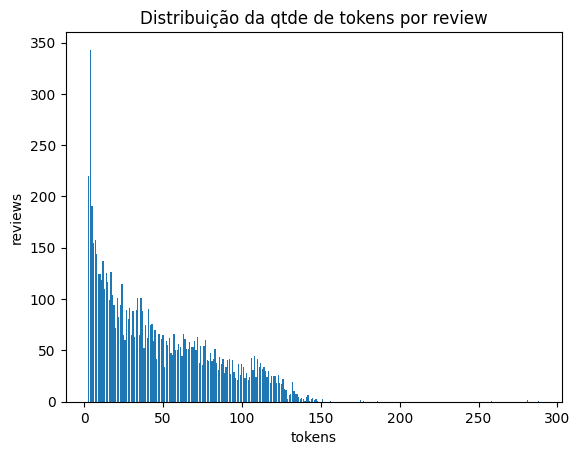

In [16]:
# Plota a distribuição do tamanho das sequencias
#plt.hist(token_lens, bins=30)

plt.bar(np.unique(token_lens, return_counts=True)[0], np.unique(token_lens, return_counts=True)[1])
plt.xlabel('tokens')
plt.ylabel('reviews')
plt.title('Distribuição da qtde de tokens por review')
plt.show()

In [37]:
# Define o tamanho máximo da sequência de tokens baseado na distribuição
MAX_LEN = 180

## Modelagem

Modelos pré-treinados na lingua portuguesa: 

* distilbert-base-multilingual-cased
* adalbertojunior/distilbert-portuguese-cased
* neuralmindbert-base-portuguese-cased

Separação em conjunto de treino e conjunto de teste com holdout

In [38]:

test_size = 0.20 # tamanho do conjunto de teste
seed = 7 # semente aleatória

# Separando entrada e saída
X = dataset['content']  # Texto do review limpo
y = dataset['sentiment'] # Sentimento 0(negativo)/2(negativo)

# Dividindo os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=test_size, shuffle=True, random_state=seed, stratify=y) # holdout com estratificação

# Parâmetros e partições da validação cruzada
scoring = 'accuracy'
num_particoes = 10
kfold = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=seed) # validação cruzada com estratificação



### Treinamento e teste do modelo

In [39]:
# Verifica se a GPU está disponível
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

NUM_EPOCH = 10

# Função para calcular métricas
def compute_metrics(eval_pred):
    load_accuracy = load_metric("accuracy")
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]
    return {"accuracy": accuracy}

# Função para treinar e avaliar o modelo
def train_and_evaluate(model_name):
    # Carrega o tokenizer e o modelo
    tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=False)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(set(y_train)), ignore_mismatched_sizes=True)
    model.to(device)

    # Tokeniza os dados de treino e teste

    tokenized_train = tokenizer(
        X_train.tolist(),  # passa a lista de textos diretamente
        max_length=MAX_LEN,
        add_special_tokens=True,
        truncation=True,
        #padding=True,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt'
    )

    tokenized_test = tokenizer(
        X_test.tolist(),  # passa a lista de textos diretamente
        max_length=MAX_LEN,
        add_special_tokens=True,
        truncation=True,
        #padding=True,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt'
    )

    # Data collator
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    # Define argumentos de treinamento
    training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=NUM_EPOCH,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir='./logs',
        logging_steps=10,
        evaluation_strategy="epoch"
    )

    # Define o Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=Dataset.from_dict({"input_ids": tokenized_train["input_ids"],
                                         "attention_mask": tokenized_train["attention_mask"],
                                         "labels": y_train}),
        eval_dataset=Dataset.from_dict({"input_ids": tokenized_test["input_ids"],
                                        "attention_mask": tokenized_test["attention_mask"],
                                        "labels": y_test}),
        data_collator=data_collator,
        compute_metrics=compute_metrics
    )

    # Treina o modelo
    trainer.train()

    # Testa o modelo
    eval_results = trainer.evaluate()
    return  eval_results["eval_accuracy"], model, tokenizer

# Lista de modelos a serem testados
model_names = [
#    'neuralmind/bert-base-portuguese-cased',
    'distilbert/distilbert-base-multilingual-cased',
    'adalbertojunior/distilbert-portuguese-cased' #Equivalente ao bert-base-portuguese-cased porém menor
]

# Exibe a acuracia de cada modelo
results = {}
best_model = None
best_tokenizer = None
best_accuracy = 0
for model_name in model_names:
    accuracy, model, tokenizer = train_and_evaluate(model_name)
    results[model_name] = accuracy
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model
        best_tokenizer = tokenizer    
    print(f"Model: {model_name}, Accuracy: {accuracy}")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.439100,0.378229,0.831250
2,0.186200,0.427301,0.864375
3,0.286700,0.473729,0.876250
4,0.162100,0.570337,0.882500
5,0.339000,0.566602,0.891875
6,0.029800,0.760749,0.886875
7,0.065200,0.783295,0.891875
8,0.111400,0.847082,0.890000
9,0.001400,0.885558,0.891875
10,0.001000,0.908087,0.891875


Model: distilbert/distilbert-base-multilingual-cased, Accuracy: 0.891875


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at adalbertojunior/distilbert-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.355700,0.308503,0.872500
2,0.232700,0.401414,0.880000
3,0.113400,0.513453,0.893125
4,0.001700,0.602968,0.895000
5,0.195400,0.601844,0.900000
6,0.001000,0.652630,0.902500
7,0.033600,0.744351,0.896875
8,0.001600,0.789487,0.903750
9,0.001700,0.827891,0.902500
10,0.001500,0.864918,0.903125


Model: adalbertojunior/distilbert-portuguese-cased, Accuracy: 0.903125


### Melhor modelo

In [40]:
# Melhor modelo
print(f"Best Model: {best_model.config._name_or_path}, Accuracy: {best_accuracy}")

Best Model: adalbertojunior/distilbert-portuguese-cased, Accuracy: 0.903125


### Simulando a aplicação do modelo em dados não vistos

In [70]:
# Novos dados - não sabemos a classe!
data = [
    'Excelente app! A entrega foi super rápida, e a comida chegou quentinha. Adorei a variedade de restaurantes disponíveis. Super recomendo para quem gosta de praticidade!', # 1 (Positivo)
    'O melhor app de delivery que já usei! Além das opções saudáveis, a entrega é sempre no horário e com um ótimo atendimento. Nota 10!', # 1 (Positivo)
    'Horrível! Além de demorar, o pedido veio errado. O suporte foi inútil e não resolveu o problema. Nunca mais uso esse app! 👎😡' # 0 (Negativo)    
    'Aplicativo maravilhoso! A interface é linda e super fácil de usar. Os cupons de desconto são um bônus que faz toda a diferença! 🤑💯', # 1 (Positivo)
    'Gostei muito do app! A função de rastreamento em tempo real da entrega é excelente. Nunca mais fiquei na dúvida sobre o horário de chegada!', # 1 (Positivo)
    'A experiência foi frustrante. O aplicativo travou várias vezes, e meu pedido chegou errado. Além disso, o suporte ao cliente demorou muito para responder.', # 0 (Negativo)
    'Esperava mais do serviço. A comida chegou fria e com apresentação ruim. O app tem um layout bonito, mas isso não compensa a má qualidade da entrega.', # 0 (Negativo)
    'Péssimo! A entrega demorou quase duas horas e, quando finalmente chegou, a comida estava completamente gelada. Não recomendo. ', # 0 (Negativo)
    'Fiquei muito decepcionado. A interface do app é confusa e difícil de navegar. Além disso, tive problemas ao tentar finalizar o pagamento. Não usarei novamente.', # 0 (Negativo)
    'O aplicativo é super intuitivo e fácil de usar. Encontrei meus drinks favoritos em minutos, e o pagamento foi muito simples. Perfeito para uma noite em casa!', # 1 (Positivo)    
]

def predict(texts, tokenizer, model, device):
    inputs = tokenizer(texts, max_length=40, add_special_tokens=True, truncation=True, padding='max_length', return_attention_mask=True, return_tensors='pt')
    inputs = {key: value.to(device) for key, value in inputs.items()}
    outputs = model(**inputs)
    predictions = np.argmax(outputs.logits.detach().cpu().numpy(), axis=-1)
    return predictions

predictions = predict(data, best_tokenizer, best_model, 'cpu')
print(f"Predictions: {predictions}")


Predictions: [1 1 0 1 0 0 0 0 1]


### Salvando os arquivos

In [53]:
# Caminhos onde os arquivos serão salvos
model_path = "../models/tf_sentiment_classifier/"

# Mover o modelo para a CPU antes de salvar
best_model.cpu()

# Salva o melhor modelo e tokenizer
best_model.save_pretrained(model_path)
best_tokenizer.save_pretrained(model_path)

('../models/tf_sentiment_classifier/tokenizer_config.json',
 '../models/tf_sentiment_classifier/special_tokens_map.json',
 '../models/tf_sentiment_classifier/vocab.txt',
 '../models/tf_sentiment_classifier/added_tokens.json',
 '../models/tf_sentiment_classifier/tokenizer.json')

### Teste do modelo salvo

In [73]:
# Caminhos onde os arquivos foram salvos
model_path = "../models/tf_sentiment_classifier/"

# Novos dados - não sabemos a classe!
data = [ 
        'Muito bom!', # 1 (Positivo)
        'Droga.', # 0 (Negativo)
        'Muito ruim esse tempo.' # 0 (Negativo)
]

# Carrega o modelo e tokenizer do disco salvos para inferência

model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

predictions = predict(data, tokenizer, model, 'cpu')
print(f"Predictions: {predictions}")

Predictions: [1 0 0]
